In [ ]:
http://be.amazd.com/link-prediction/
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf

In [19]:

import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os

import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


num_followers_d

In [ ]:
# Adding the feature num_followers_d ie.Number of followers for destination vertex

In [21]:
def num_followers_for_d(df_final):
    num_followers_d=[]
    for i,row in df_final.iterrows():
        try:
            d=set(train_graph.predecessors(row['destination_node']))
        except:
            d=set()
            
        num_followers_d.append(len(d))

    return  num_followers_d

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    
    df_final_train['num_followers_d'] = num_followers_for_d(df_final_train)
    df_final_test['num_followers_d'] = num_followers_for_d(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

Preferential Attachment 

In [3]:
# Function to calculate preferential attachment for followers
def preferential_attachment_followers(s,d):
    try:
        s1=set(train_graph.predecessors(s))
        s2=set(train_graph.predecessors(d))
    except:
        return 0
    pref_attach=(len(s1)*len(s2))
        
    return pref_attach



# Function to calculate preferential attachment for followees
def preferential_attachment_followees(s,d):
    try:
        s1=set(train_graph.successors(s))
        s2=set(train_graph.successors(d))
    except:
        return 0
    pref_attach=(len(s1)*len(s2))
        
    return pref_attach

In [4]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):

    #mapping preferential_attachment_for_followers on train data
    df_final_train['preferential_attachment_for_followers'] = df_final_train.apply(lambda row: preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping preferential_attachment_for_followees on train data
    df_final_train['preferential_attachment_for_followees'] = df_final_train.apply(lambda row: preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)


    #mapping preferential_attachment_for_followers on test data
    df_final_test['preferential_attachment_for_followers'] = df_final_test.apply(lambda row: preferential_attachment_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping preferential_attachment_for_followees on test data
    df_final_test['preferential_attachment_for_followees'] = df_final_test.apply(lambda row: preferential_attachment_followees(row['source_node'],row['destination_node']),axis=1)


    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

 SVD_Dot Feature

In [23]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):

    # Svd_dot_u and svd_dot_v feature for train data
    df_final_train['svd_dot_u']=(df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1'])+(df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2'])+(df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3'])+(df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4'])+(df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5'])+(df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6'])
    df_final_train['svd_dot_v']= (df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1'])+(df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2'])+(df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3'])+(df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4'])+(df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5'])+(df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6'])

   # Svd_dot_u and svd_dot_v feature for test data
    df_final_test['svd_dot_u']=(df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1'])+(df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2'])+(df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3'])+(df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4'])+(df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5'])+(df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6'])
    df_final_test['svd_dot_v']=(df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1'])+(df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2'])+(df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3'])+(df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4'])+(df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5'])+(df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6'])

   
    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [29]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attachment_for_followers,preferential_attachment_for_followees,svd_dot_u,svd_dot_v,num_followers_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114958e-11,2.238775e-12,6
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,3.192812e-03,9.068719e-04,94
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902,1.787503e-35,2.467873e-36,28
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,22,35,4.710376e-20,3.159386e-18,11
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,33,7.773952e-14,0.000000e+00,1


In [28]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attachment_for_followers',
       'preferential_attachment_for_followees', 'svd_dot_u', 'svd_dot_v',
       'n

Modelling

In [164]:

df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [165]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [166]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [167]:
df_final_train

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attachment_for_followers,preferential_attachment_for_followees,svd_dot_u,svd_dot_v,num_followers_d
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114958e-11,2.238775e-12,6
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,3.192812e-03,9.068719e-04,94
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902,1.787503e-35,2.467873e-36,28
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,22,35,4.710376e-20,3.159386e-18,11
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,33,7.773952e-14,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99997,0,0.000000,0.000000,0.000000,7,1,10,0,0,0.000000,...,1.538318e-13,1.296745e-06,2.990887e-13,1.589668e-12,7.338551e-14,0,10,-8.826350e-26,0.000000e+00,7
99998,0,0.000000,0.000000,0.000000,0,4,1,0,0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,4,1.428815e-31,0.000000e+00,0
99999,0,0.000000,0.000000,0.000000,0,5,1,0,0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,5,4.158491e-22,0.000000e+00,0
100000,0,0.000000,0.000000,0.000000,1,2,0,0,0,0.000000,...,5.200344e-17,3.858875e-15,2.173437e-17,2.241477e-16,3.528355e-20,1,0,4.300967e-30,6.252591e-26,1


In [168]:
y_train

0         1
1         1
2         1
3         1
4         1
         ..
99997     0
99998     0
99999     0
100000    0
100001    0
Name: indicator_link, Length: 100002, dtype: int64

 Random forest

Estimators =  10 Train Score 0.8867617497846272 test Score 0.8639396828148019
Estimators =  50 Train Score 0.9198501092953054 test Score 0.9143884290611153
Estimators =  100 Train Score 0.9202755291032817 test Score 0.8825452824506302
Estimators =  250 Train Score 0.9198932465961928 test Score 0.8871912619900861
Estimators =  450 Train Score 0.9206319411856718 test Score 0.8991008991008991


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

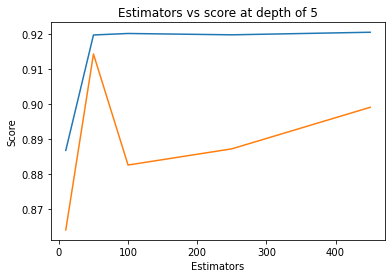

In [108]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8651316830325595 test Score 0.8432880715022345
depth =  9 Train Score 0.9585357425963942 test Score 0.9076676975578544
depth =  11 Train Score 0.9608188912536739 test Score 0.9231253805934108
depth =  15 Train Score 0.9640133291468738 test Score 0.9212842758533342
depth =  20 Train Score 0.9658440954748478 test Score 0.9067151411462788
depth =  35 Train Score 0.9658181818181819 test Score 0.9063788866331872
depth =  50 Train Score 0.9658181818181819 test Score 0.9063788866331872
depth =  70 Train Score 0.9658181818181819 test Score 0.9063788866331872
depth =  130 Train Score 0.9658181818181819 test Score 0.9063788866331872


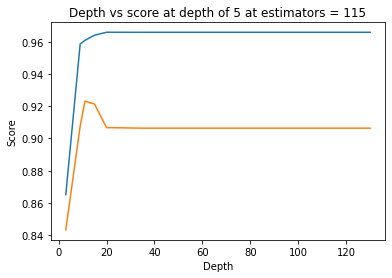

In [111]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 50)
plt.show()

In [113]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(50,110),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96171936 0.96283605 0.96011604 0.9622274  0.96352589]
mean train scores [0.96262837 0.96373152 0.96069507 0.96275266 0.96473447]


In [114]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=72, n_jobs=-1, random_state=25)


In [117]:
clf =RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=72, n_jobs=-1, random_state=25)

In [118]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [126]:
from sklearn.metrics import f1_score

tr_f1_rf=f1_score(y_train,y_train_pred)
test_f1_rf=f1_score(y_test,y_test_pred)
best_n_estimators_rf=clf.n_estimators
best_depth_rf=clf.max_depth
min_samples_split_rf=clf.min_samples_split
min_samples_leaf_rf=clf.min_samples_leaf

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9647840935577693
Test f1 score 0.91917631372881


In [120]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


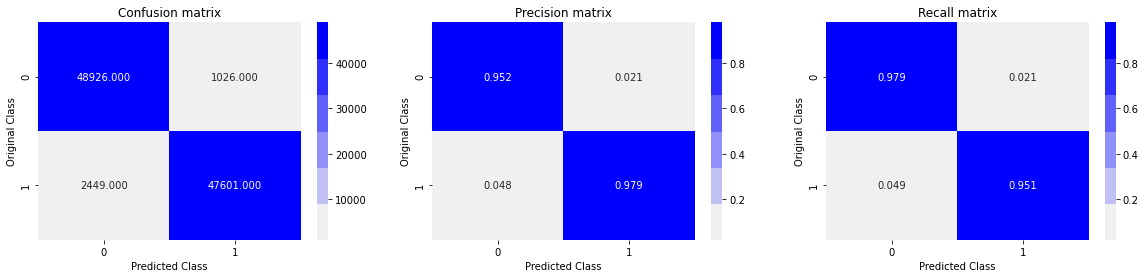

Test confusion_matrix


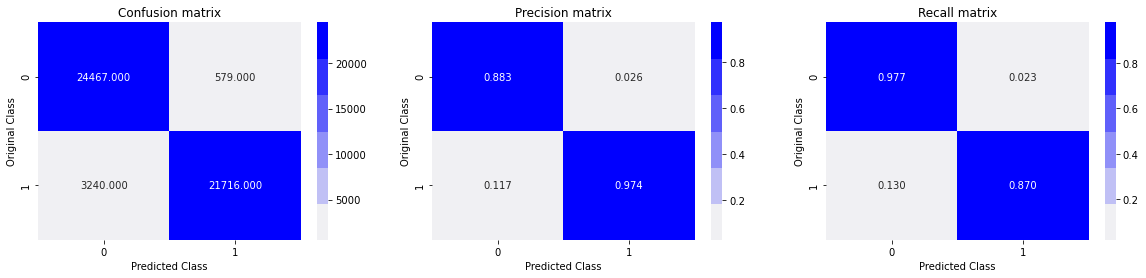

In [121]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

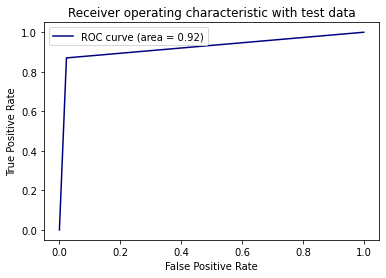

In [122]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

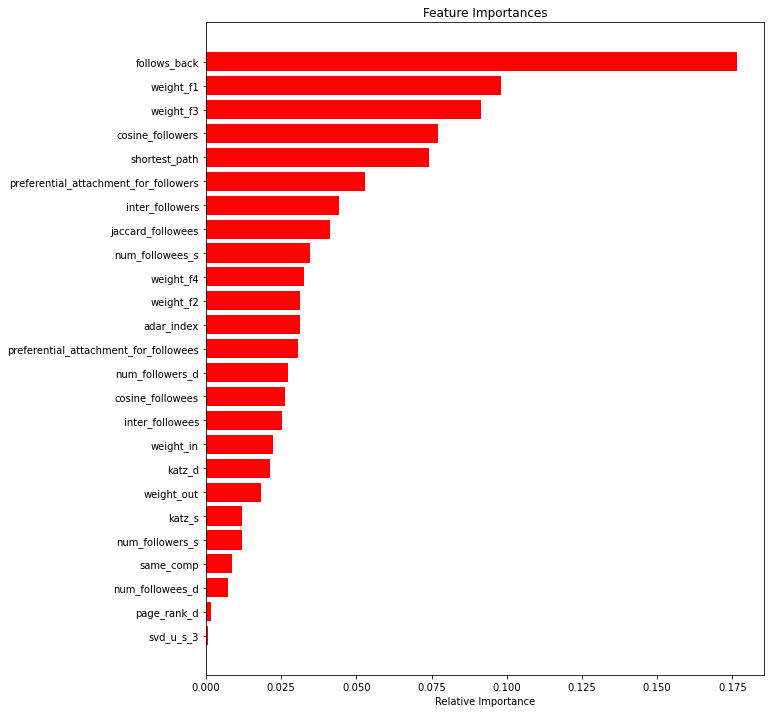

In [123]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

XGBoost

Estimators =  10 Train Score 0.9568271354840023 test Score 0.8813092688895686
Estimators =  50 Train Score 0.9791988373149241 test Score 0.900733134640068
Estimators =  100 Train Score 0.9853276883315399 test Score 0.9112627251791747
Estimators =  250 Train Score 0.9959668945087717 test Score 0.901685637327309
Estimators =  450 Train Score 0.9993105446697109 test Score 0.8970841602512376


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

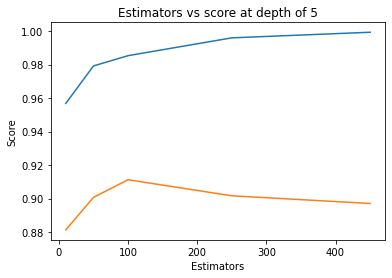

In [179]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=5,n_estimators=i, n_jobs=-1,random_state=25,colsample_bytree = 0.3,alpha=5,
                        eta = 0.3,verbosity=0)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9783755966135559 test Score 0.8970405426035374
depth =  9 Train Score 0.9983106588430511 test Score 0.9080122535272036
depth =  11 Train Score 0.9993406066418895 test Score 0.9075253037529404
depth =  15 Train Score 0.9997103099683339 test Score 0.9071057117579785
depth =  20 Train Score 0.9997802461243407 test Score 0.907132083602672
depth =  35 Train Score 0.999790241222594 test Score 0.9085820092150023
depth =  50 Train Score 0.9998002237494007 test Score 0.906907554329079
depth =  70 Train Score 0.9998002237494007 test Score 0.906907554329079
depth =  130 Train Score 0.9998002237494007 test Score 0.906907554329079


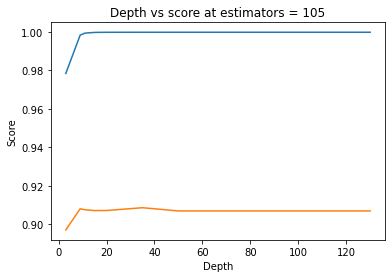

In [180]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = xgb.XGBClassifier(max_depth=i,n_estimators=105, n_jobs=-1,random_state=25,colsample_bytree = 0.3,alpha=5,
                        eta = 0.3,verbosity=0)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 105')
plt.show()

In [169]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

clf_xgb = xgb.XGBClassifier(verbosity=0)


parameters = {'n_estimators':sp_randint(100,120),
             "eta"    : [0.02,0.05,0.1,0.20,0.30,0.5,1] ,
             "max_depth" : sp_randint(10,15),
            "alpha": [0.001,0.01,0.1,1.10]}
# "gamma" : [0.1,0.5,1,5,10,25,50]


xgb_clf = RandomizedSearchCV(clf_xgb, param_distributions=parameters,n_iter=5,cv=10,scoring='f1',
                              random_state=25,verbose=10,return_train_score=True)

xgb_clf.fit(df_final_train,y_train)
print('mean test scores',xgb_clf.cv_results_['mean_test_score'])
print('mean train scores',xgb_clf.cv_results_['mean_train_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START alpha=0.001, eta=1, max_depth=12, n_estimators=115.........
[CV 1/10; 1/5] END alpha=0.001, eta=1, max_depth=12, n_estimators=115; total time=  33.5s
[CV 2/10; 1/5] START alpha=0.001, eta=1, max_depth=12, n_estimators=115.........
[CV 2/10; 1/5] END alpha=0.001, eta=1, max_depth=12, n_estimators=115; total time=  39.3s
[CV 3/10; 1/5] START alpha=0.001, eta=1, max_depth=12, n_estimators=115.........
[CV 3/10; 1/5] END alpha=0.001, eta=1, max_depth=12, n_estimators=115; total time=  37.4s
[CV 4/10; 1/5] START alpha=0.001, eta=1, max_depth=12, n_estimators=115.........
[CV 4/10; 1/5] END alpha=0.001, eta=1, max_depth=12, n_estimators=115; total time=  37.4s
[CV 5/10; 1/5] START alpha=0.001, eta=1, max_depth=12, n_estimators=115.........
[CV 5/10; 1/5] END alpha=0.001, eta=1, max_depth=12, n_estimators=115; total time=  37.9s
[CV 6/10; 1/5] START alpha=0.001, eta=1, max_depth=12, n_estimators=115.........
[CV

[CV 8/10; 5/5] END alpha=0.01, eta=0.2, max_depth=10, n_estimators=103; total time=  41.5s
[CV 9/10; 5/5] START alpha=0.01, eta=0.2, max_depth=10, n_estimators=103........
[CV 9/10; 5/5] END alpha=0.01, eta=0.2, max_depth=10, n_estimators=103; total time=  40.4s
[CV 10/10; 5/5] START alpha=0.01, eta=0.2, max_depth=10, n_estimators=103.......
[CV 10/10; 5/5] END alpha=0.01, eta=0.2, max_depth=10, n_estimators=103; total time=  40.8s
mean test scores [0.98047446 0.98031145 0.97620824 0.98099354 0.98165785]
mean train scores [1.         1.         0.99078525 1.         0.999869  ]


In [170]:
print(xgb_clf.best_estimator_)

XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.2, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.200000003,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=103, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.00999999978, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)


In [171]:
clf=xgb.XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.2, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.200000003,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=103, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.00999999978, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [172]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [173]:
from sklearn.metrics import f1_score

tr_f1_xgb=f1_score(y_train,y_train_pred)
test_f1_xgb=f1_score(y_test,y_test_pred)
best_n_estimators_xgb=clf.n_estimators
best_depth_xgb=clf.max_depth

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9997701769637379
Test f1 score 0.9262129737764093


In [174]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]

    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


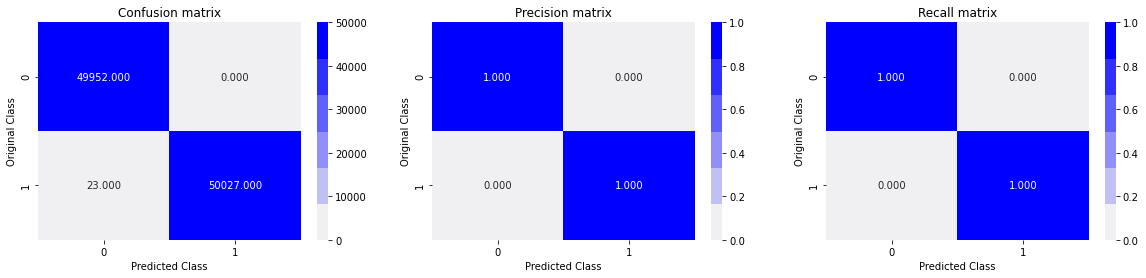

Test confusion_matrix


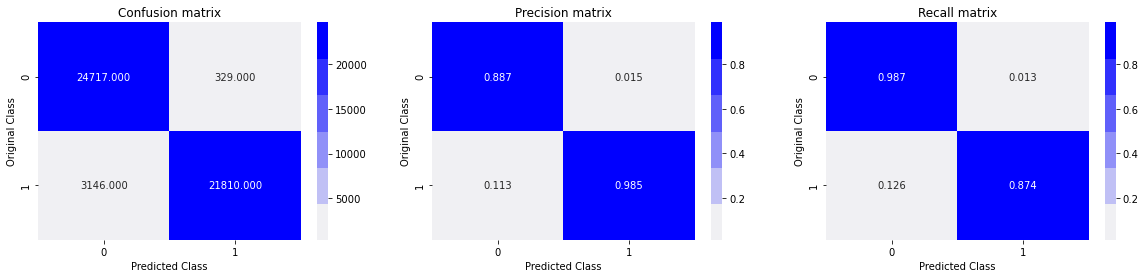

In [175]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

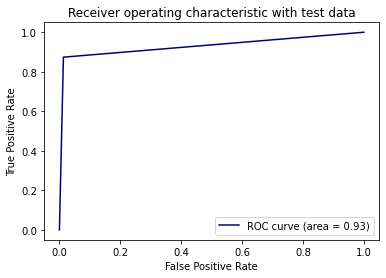

In [176]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

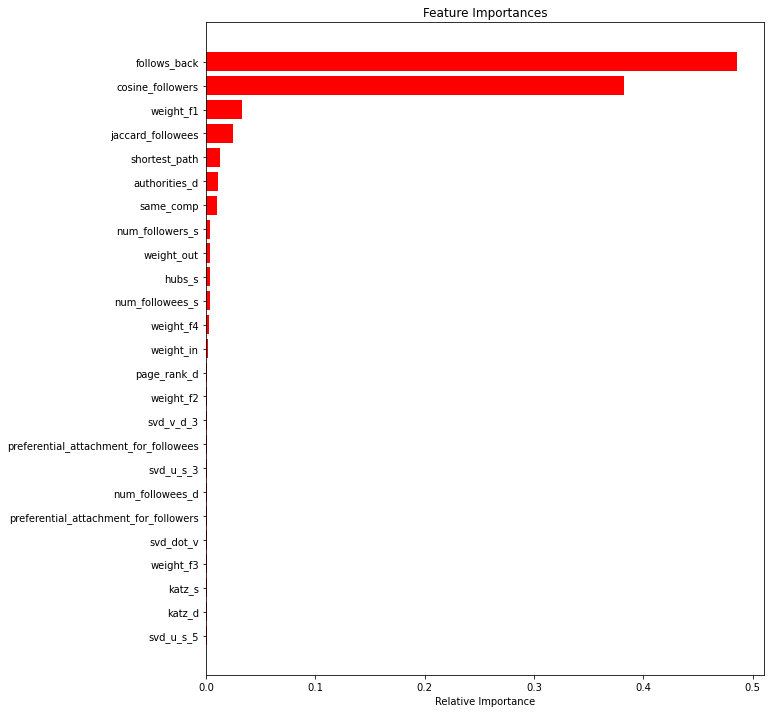

In [177]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [92]:
# feature_important = clf.get_booster().get_score(importance_type='weight')
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
# data.nlargest(30, columns="score").plot(kind='barh', figsize = (10,20)) ## plot top 30 features
# plt.title('Feature Importances')

In [178]:
from prettytable import PrettyTable

summary_table = PrettyTable(["Classifier", "max_depth","n_estimators", "Train F1 score", "Test F1 score"])

summary_table.add_row(["Random Forest", best_depth_rf,best_n_estimators_rf,tr_f1_rf, test_f1_rf])
summary_table.add_row(["XGBoost", best_depth_xgb,best_n_estimators_xgb,tr_f1_xgb, test_f1_xgb])
print(summary_table )

+---------------+-----------+--------------+--------------------+--------------------+
|   Classifier  | max_depth | n_estimators |   Train F1 score   |   Test F1 score    |
+---------------+-----------+--------------+--------------------+--------------------+
| Random Forest |     14    |      72      | 0.9647840935577693 |  0.91917631372881  |
|    XGBoost    |     10    |     103      | 0.9997701769637379 | 0.9262129737764093 |
+---------------+-----------+--------------+--------------------+--------------------+


#### Conclusion

- Initially we have data for time t in form of [source vertex,destination vertex] so using networkx package we created directed graph.


- Then we did basic EDA based on features such as No. of followers for each person, No of people each person is following etc.


- We find missing edges from graph ie. nodes that do not have edges between them and then do random train-test split as 80-20 split and create our dataset consisting on three columns as [source vertex,destination vertex,indicator link] where indicator_link=1 if edge is present between source vertex and destination vertex else 0.


- We find out that our dataset has partial cold start problem as there are upto 7% of people which are not there in Train data 
   but exist in our Test data ie.we dont have any information about these nodes in train data to predict for them.
   
   
- Then we do featurization and find various features based on similarity measures like jaccard and cosine distance, ranking measures like page-rank, graph based features like shortest path weakly connected components and checking if nodes belonging to same community, adar index , kartz centrality, HITS score etc. and various other features like number of followers,svd features,preferential attachment etc.


- Networkx package makes the task of calculating these features easy due to various built-in functions to work with graphs.


- We use F1-score and confusion matrix as our performance metric.


- Then we train RandomForest and XGBoost models on train-data and perform hyper-parameter tuning and test the models on test-data and find most feature importance.